# Example usage

This notebook will guide you through:
- Creating a simple prompt
- Testing prompt quality with real-world data
- Analyzing and visualizing results

## Creating your first prompt

Pochemuchka uses a simple prompt creation interface. A Prompt object serves as a container for your prompt template, which can include dynamic variables enclosed in `{variable_name}` syntax.

Below, we'll create a medical question-answering prompt:

In [ ]:
from pochemuchka import Prompt

# create a prompt with unique ID
agent = Prompt("answer_on_medical_question")

# add instructions with a dynamic variable for the question
agent.add("""Answer on medical question of the user:
{question}
          
Please first think out loud before answering.
""", role="system")

# the {question} placeholder will be filled with actual questions at runtime

## Setting up the client

Now let's initialize the Pochemuchka client with your API keys. We'll also set up the testing pipeline that will help us evaluate our prompt quality.

In [ ]:
import os
from pochemuchka import Pochemuchka
from response_parser import get_json_from_response

# get API keys from environment variables
openai_key = os.getenv("OPENAI_API_KEY")

# initialize the client
client = Pochemuchka(openai_key=openai_key)

In [ ]:
# load our test sample dataset
data_df = pd.read_csv('./data/medical_questions_answers.csv')
data_df.head()

,question,answer_provided_by_human
0,I have a headache that won't go away. What cou...,"Headaches can have many causes, including stre..."
1,I've been feeling tired all the time lately. W...,Fatigue can be a symptom of various conditions...
2,I have a cough that's been lingering for weeks...,A persistent cough can be a sign of several co...
3,I've noticed a lump in my breast. Is it cancer?,"Finding a lump in your breast can be alarming,..."
4,My child has a fever. When should I take them ...,Fever is a common symptom in children and can ...


In [ ]:
# process each test case
results = []
for index, row in data_df.iterrows():
    print(f"Processing test case {index+1}/{len(data_df)}")
    
    # extract question and ideal answer from our dataset
    question = row['question']
    ideal_answer = row['answer_provided_by_human']
    
    try:
        # prepare the context (variables that will be injected into our prompt)
        context = {
            'question': question,
            'ideal_answer': ideal_answer, # this won't be shown to the LLM but used for evaluation
        }
        
        # call the LLM with our prompt, context and model; the test_data parameter enables automatic test creation in Pochemuchka
        response = client.call(
            agent.id, # the prompt ID we created earlier
            context, # variables to inject into the prompt
            'openai/o3-mini',
            test_data={
                'ideal_answer': ideal_answer
            }
        )
        results.append({
            'question': question,
            'ideal_answer': ideal_answer,
            'response': response.content,
        })
        
    except Exception as e:
        print(f"Error processing test case {index}: {e}")

Processing test case 1/20
Processing test case 2/20
Processing test case 3/20
Processing test case 4/20
Processing test case 5/20
Processing test case 6/20
Processing test case 7/20
Processing test case 8/20
Processing test case 9/20
Processing test case 10/20
Processing test case 11/20
Processing test case 12/20
Processing test case 13/20
Processing test case 14/20
Processing test case 15/20
Processing test case 16/20
Processing test case 17/20
Processing test case 18/20
Processing test case 19/20
Processing test case 20/20


## Visualize test results

Pochemuchka provides built-in visualization tools to help you understand your prompt's performance. Let's get a summary of our test results:

In [ ]:
! pip install pochemuchka_cicd

from pochemuchka_cicd import TestLLMResponsePipe

# initialize testing pipeline
pochemuchka_pipe = TestLLMResponsePipe(openai_key=openai_key)

In [ ]:
# process each test case
cicd_pipeline_results = []

for row in results:
    try:
        # compare the LLM's response to our ideal answer
        test_result = pochemuchka_pipe.compare(row['ideal_answer'], row['response'], optional_params={'question': row['question']})

        # store the results for later analysis
        pochemuchka_pipe.accumulated_results.append(test_result)
        cicd_pipeline_results.append(test_result)
        
    except Exception as e:
        print(f"Error processing test case {index}: {e}")

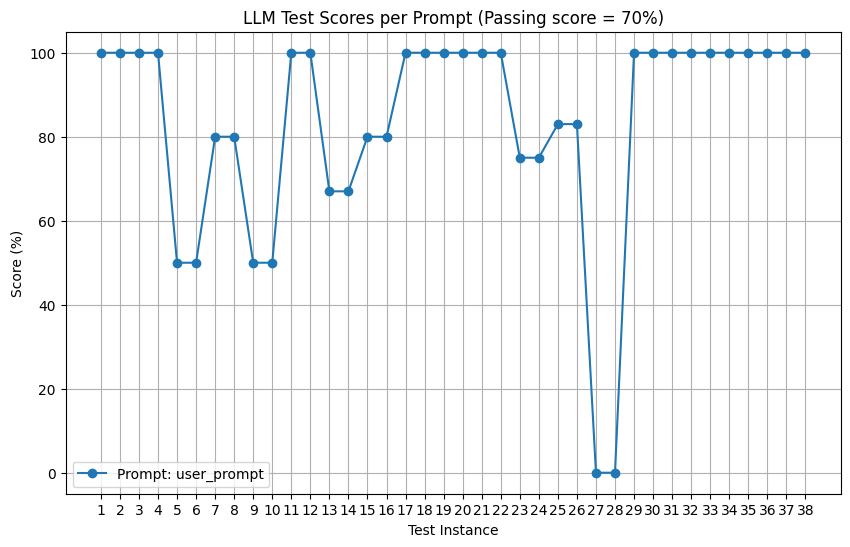

In [ ]:
pochemuchka_pipe.visualize_test_results()